# UCI Car Evaluation - Exploratory Data Analysis


In this project, we'll be exploring the Car Evaluation Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/19/car+evaluation). The dataset was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic. The model evaluates cars according to overall price and technical characteristics.

## Contents

1. [**Overview**](#1.-Overview)
2. [**Exploratory Data Analysis**](#2.-Exploratory-Data-Analysis)
3. [**Performance Evaluation**](#3.-Performance-Evaluation)
4. [**Feature Importance**](#4.-Feature-Importance)
5. [**Decision Tree Analysis**](#5.-Decision-Tree-Analysis)

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

import shap

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, roc_auc_score, precision_score

import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
warnings.filterwarnings('ignore') 

sns.set(font_scale=1.2)
sns.set_palette("pastel")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1. Overview
___

The dataset comprises 1728  of cars evaluation according to price and confort concepts.

### Dataset columns description

- **buying** : buying price
- **maint**: price of maintenance
- **doors**: number of doors
- **persons**: capacity in terms of persons to carry
- **lug_boot**: size of luggage boot
- **safety**: estimated safety of the car
- **class**: car class

## 2. Exploratory Data Analysis
___

### Loading Data

Loading the Car Evaluation dataset from ucimlrepo library into a **pandas dataframe**:

In [2]:
car_evaluation = fetch_ucirepo(id=19) 
  
X = car_evaluation.data.features 
y = car_evaluation.data.targets 

In [3]:
df_orig = pd.concat([X,y],axis=1)

In [4]:
df_orig.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


The dataset does not have any missing values, eliminating the need for special treatments to fill in null values. 

### Target class distribution

From the graph plot below, we can see that the dataset shows a notable imabalance in the data, with the majority of car evaluations being negative (labeled as `unacc`), suggesting a lack of market acceptability for the analysed vehicle. 

We'll have to tackle the imbalance issue when training our classification model.

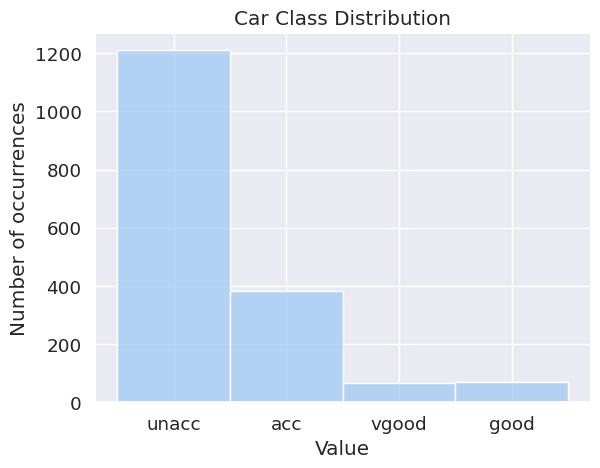

In [6]:
sns.histplot(df_orig["class"])
plt.title('Car Class Distribution')
plt.xlabel('Value')
plt.ylabel('Number of occurrences')
plt.show()

We'll be manipulating some of the data, so let's create a copy of the dataframe:

In [7]:
df = df_orig.copy()

### Listing unique values

All columns from the dataset contain categorical data, suggesting they represent distinct categories or groups rather than continuous numerical values. 

Given this data nature, it's necessary to convert these categorical data into numerical values prior to the implementation of out classification model.

First, let's begin by listing the unique value of each variable.

In [8]:
for column in df.columns:
    print(f"{column}: {df[column].unique()}")

buying: ['vhigh' 'high' 'med' 'low']
maint: ['vhigh' 'high' 'med' 'low']
doors: ['2' '3' '4' '5more']
persons: ['2' '4' 'more']
lug_boot: ['small' 'med' 'big']
safety: ['low' 'med' 'high']
class: ['unacc' 'acc' 'vgood' 'good']


### Enconding the data

The variables are categorical ordinal data, which means that they represent categories with a defined order or ranking. 

Therefore, we need to encode them in order to preserve their ordinal nature during analysis.

In [9]:
price_map = {"low":0, "med":1, "high":2, "vhigh":3}
doors_map = {"2":0, "3":1, "4":2, "5more":3}
persons_map = {"2":0, "4":1, "more":2}
lug_boot_map = {"small":0, "med":1, "big":2}
safety_map = {"low":0, "med":1, "high":2}
class_map = {"unacc":0, "acc":1, "good":2, "vgood":3}

df["buying"] = df["buying"].replace(price_map)
df["maint"] = df["maint"].replace(price_map)
df["doors"] = df["doors"].replace(doors_map)
df["persons"] = df["persons"].replace(persons_map)
df["lug_boot"] = df["lug_boot"].replace(lug_boot_map)
df["safety"] = df["safety"].replace(safety_map)
df["class"] = df["class"].replace(class_map)

### Cross-category Comparisons

Here we will analyze the behavior of the car features given the car evaluation/classification. 

Additionaly, we will examine the correlation matrix to understand the relationship and level of correlation between each feature. 

In [10]:
price_map_inv = {v:k for k, v in price_map.items()}
doors_map_inv = {v:k for k, v in doors_map.items()}
persons_map_inv = {v:k for k, v in persons_map.items()}
lug_boot_map_inv = {v:k for k, v in lug_boot_map.items()}
safety_map_inv = {v:k for k, v in safety_map.items()}
class_map_inv = {v:k for k, v in class_map.items()}

def plot_comparison_graph(df: pd.DataFrame, x: str, y: str, xmap_inv: dict, ymap_inv: dict, title: str):
    """
    Display features comparison graph.
    
    Args:
        df(pd.DataFrame): dataframe with the data to plot the graph
        x(str): column name to plot in the x axis
        y(str): column name to plot in the y axis
        xmap_inv(dict): x axis label map
        ymap_inv(dict): y axis label map
        title(str): graph title
    """
    ax = sns.countplot(data=df, x=x, hue=y)

    xlabels = [xmap_inv[int(label.get_text())] for label in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels)

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=[ymap_inv[label] for label in df[y].unique()], title=y, loc='upper right')

    plt.title(title)
    plt.xlabel(x)
    plt.ylabel('Number of occurrences')
    plt.show()

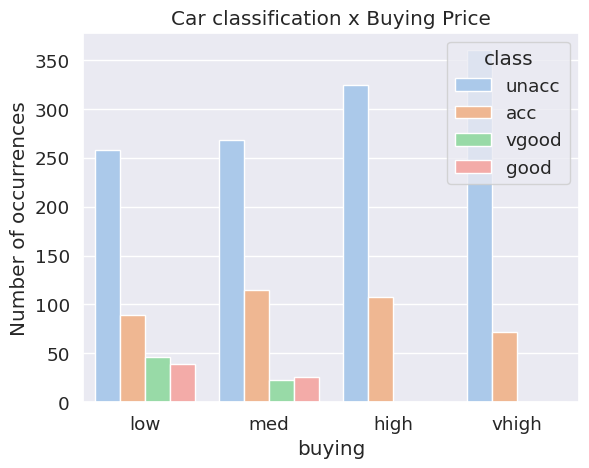

In [11]:
plot_comparison_graph(df, 'buying', 'class', price_map_inv, class_map_inv, 'Car classification x Buying Price')

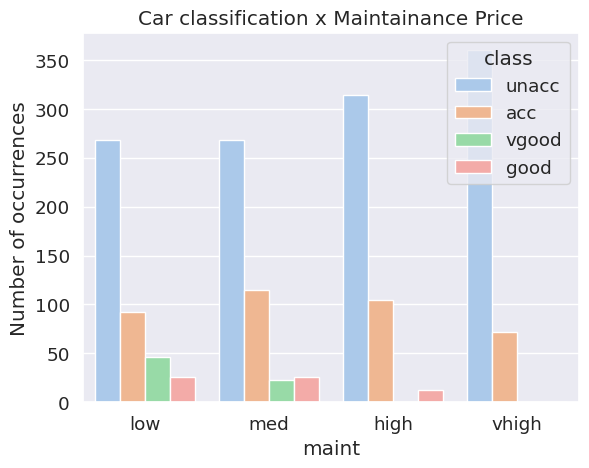

In [12]:
plot_comparison_graph(df, 'maint', 'class', price_map_inv, class_map_inv, 'Car classification x Maintainance Price')

Regardless of the selling price, there were still many negative evaluations. However, we can observe that a vehicle being classified as good or very good reflects in a low or medium vehicle price.

The maintenance price exhibited a similar behavior, where for a vehicle to be classified as very good, it needs to have a low or medium maintenance price, and for a good classification, at least a slightly higher maintenance price.

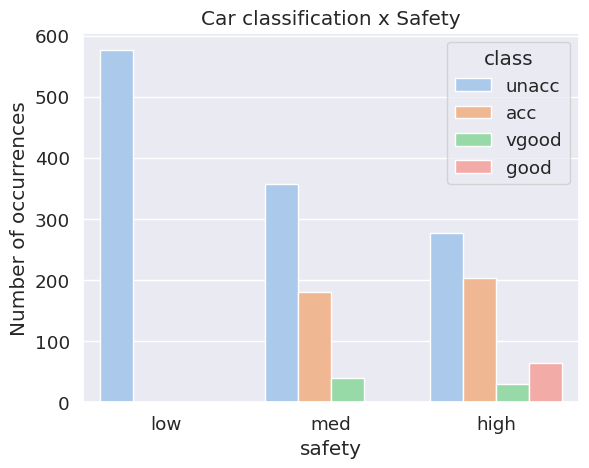

In [13]:
plot_comparison_graph(df, 'safety', 'class', safety_map_inv, class_map_inv, 'Car classification x Safety')

Regarding safety, we can see in the graph above that for a vehicle to have a good market acceptance, it needs to have at least a medium level of safety.

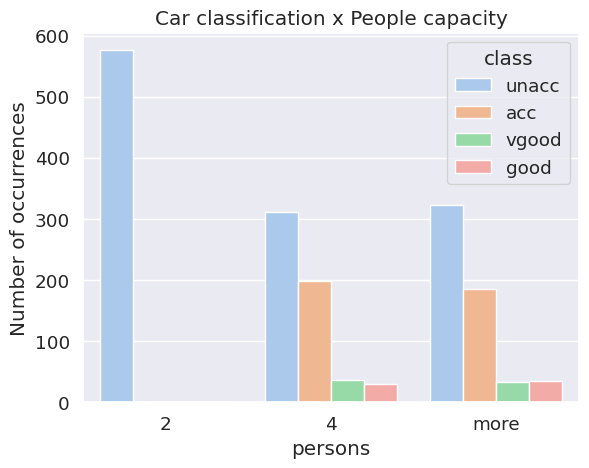

In [14]:
plot_comparison_graph(df, 'persons', 'class', persons_map_inv, class_map_inv, 'Car classification x People capacity')

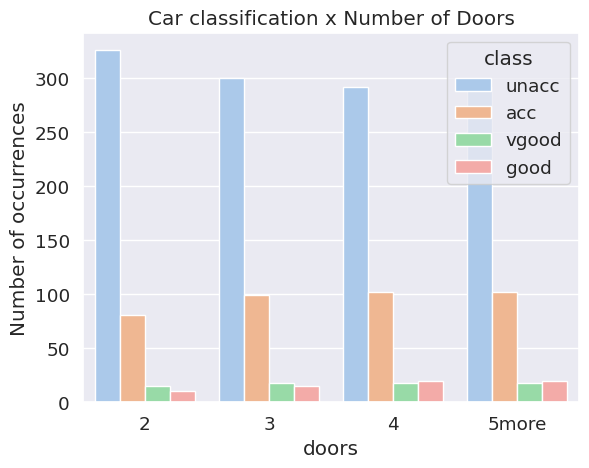

In [15]:
plot_comparison_graph(df, 'doors', 'class', doors_map_inv, class_map_inv, 'Car classification x Number of Doors')

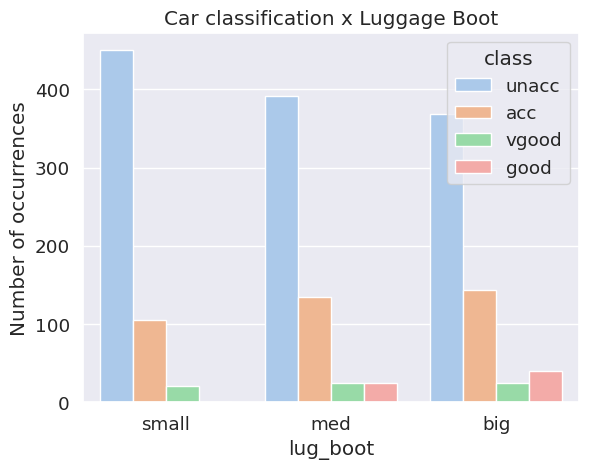

In [16]:
plot_comparison_graph(df, 'lug_boot', 'class', lug_boot_map_inv, class_map_inv, 'Car classification x Luggage Boot')

As for the number of doors and luggage boot size, these characteristics does not seem to represent significant measures for market acceptability or rejection.

### Correlation Matrix

The correlation matrix below highlights a strong negative correlation between the buying and maintenance price and market acceptability. This suggests that for higher market acceptability, the vehicles should have lower buying and maintenance prices, which aligns with our previous observations.
 
From my perspective, I had antecipated to see a strong positive correlation between the buying and maintenance price, as typically a higher-priced car reflects higher maintenance costs. 

However, the correlation matrix shows a low correlation among all the car features, suggesting that this assumption is not confirmed.

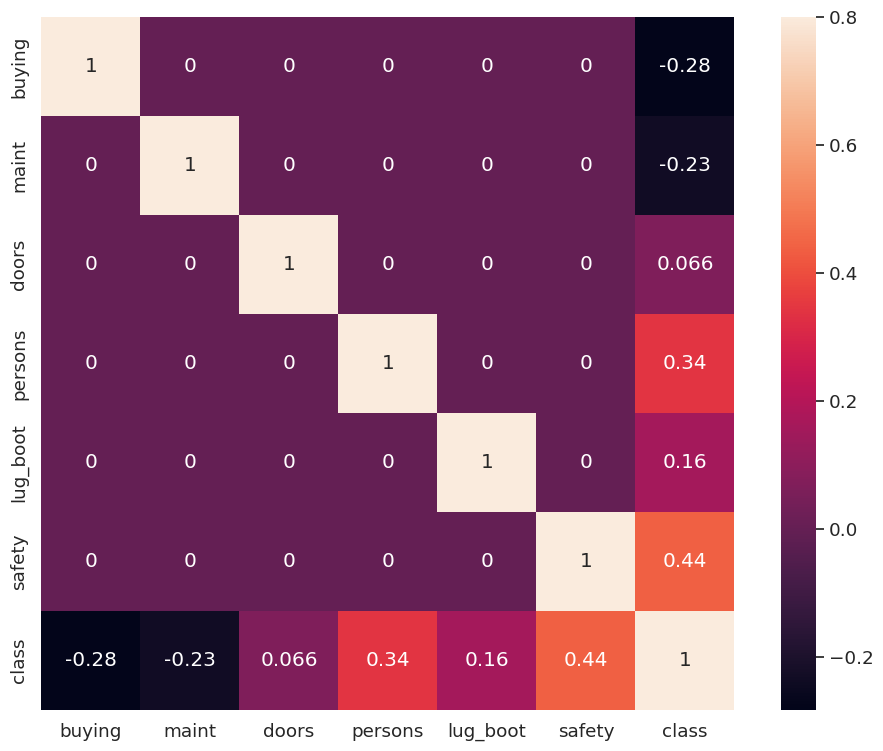

In [17]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
plt.show()

## 3. Performance Evaluation 
___
In this section, we'll be evaluating three classification algorithms: Logistic Regression, Decision Tree and Random Forest.

We begin by partitioning our data into training and testing datasets. 

We allocate 80% of the data for the training set and the remaining 20% to the testing set.

Given the dataset's imbalance, we utilize the `stratify` parameter to ensure an equitable representaion of each class by selecting an appropriate amount of data when splitting it.

In [18]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

A Grid Search is applied to select the optimal hyperparameters for the model. The metrics including accuracy, precision, recall and F1 score are stored for subsequent analysis.

In [19]:
def get_metrics(y_true: list, y_pred: list) -> [float, float, float, float]:
    """
    Calculate the classification metrics.
    
    Args:
        y_true(list): list of expected values.
        y_pred(list): list of predicted values.
    Returns:
        float: accuracy
        float: precision
        float: recall
        float: f1
    """
    cm = confusion_matrix(y_true, y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

In [20]:
models = {
    'Logistic Regression':  LogisticRegression(random_state=42),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest Classifier': RandomForestClassifier(random_state=42, class_weight='balanced')
}

param_grid = {
    'Logistic Regression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    },
    'Decision Tree Classifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20]
    },
    'Random Forest Classifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

results = {}
for model_name in models:
    grid_search = GridSearchCV(
        models[model_name],
        param_grid[model_name],
        cv=StratifiedKFold(n_splits=5),
        scoring='f1_macro',
        error_score="raise"  
    )
    grid_search.fit(X_train, y_train)
    
    y_pred = grid_search.predict(X_test)
    accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
    
    results[model_name] = {
        "Best Parameters": grid_search.best_params_,
        "Accuracy": round(accuracy,5),
        "Precision": round(precision,5),
        "Recall": round(recall,5),
        "F1 Score": round(f1,5)
    }

In [21]:
for model_name, model_metrics in results.items():
    print(f"\nModel: {model_name}\n")
    for metric in model_metrics:
        print(f"{metric}: {model_metrics[metric]}")
    print("________________________________")


Model: Logistic Regression

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.79769
Precision: 0.64271
Recall: 0.51124
F1 Score: 0.54738
________________________________

Model: Decision Tree Classifier

Best Parameters: {'criterion': 'gini', 'max_depth': None}
Accuracy: 0.98266
Precision: 0.96708
Recall: 0.93753
F1 Score: 0.95157
________________________________

Model: Random Forest Classifier

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.97399
Precision: 0.92659
Recall: 0.91539
F1 Score: 0.91939
________________________________


Based on the evaluation metrics results, the `Decision Tree Classifier` would be the best model for this classification problem.

We can see that it achieved the highest accuracy, which suggests that the model accurately classifies most examples in the test set.

In terms of Precision, the Decision Tree classifier also achieved the highest score. This indicates that among examples classified as positive by the model, the majority truly belong to the positive class.

Additionally, the Recall metric represents the proportion of true positives over the sum of true positives and false negatives, indicating the capacity of the model to correctly identify positive examples for each class.

Furthermore, the Decision Tree Classifier achieved the highest F1 Score, which is the harmonic mean between Precision and Recall. This suggests a balanced performance between precision and recall, indicating an overall solid performance of the model in classifying the examples.


## 4. Feature Importance
___

Upon evaluating the model's performance, we can now analyze the feature importances. To do so, we initially examine the `feature_importances` parameter provided by the `RandomForestClassifier` algorithm.

In [22]:
rfc = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=50)
rfc.fit(X_train, y_train)
y_test_pred = rfc.predict(X_test)
test_acc, test_prec, test_recall, test_f1 = get_metrics(y_test, y_test_pred)

print("Metrics on testing data: ")
print(f"- Accuracy: {round(test_acc, 5)}")
print(f"- Precision: {round(test_prec, 5)}")
print(f"- Recall: {round(test_recall, 5)}")
print(f"- F1 Score: {round(test_f1, 5)}")

Metrics on testing data: 
- Accuracy: 0.96243
- Precision: 0.93374
- Recall: 0.89085
- F1 Score: 0.90893


In [23]:
feature_importances = rfc.feature_importances_

In [24]:
df_importance = pd.DataFrame(feature_importances, index=X_train.columns, columns=["importance"])
df_importance_sorted = df_importance.sort_values(by="importance", ascending=False)

In [25]:
df_importance_sorted

,importance
safety,0.301272
persons,0.254185
maint,0.150363
buying,0.146752
lug_boot,0.088595
doors,0.058832


We can see that `safety` and `people capacity` are highly influential factors for market acceptability of the vehicles.

Additionally, maintenance and buying prices are also significant contributors to the vehicle evaluation.

In [26]:
explainer = shap.Explainer(rfc.predict, X_train)
shap_values = explainer(X_train)

Exact explainer: 1383it [00:28, 33.71it/s]                                                               


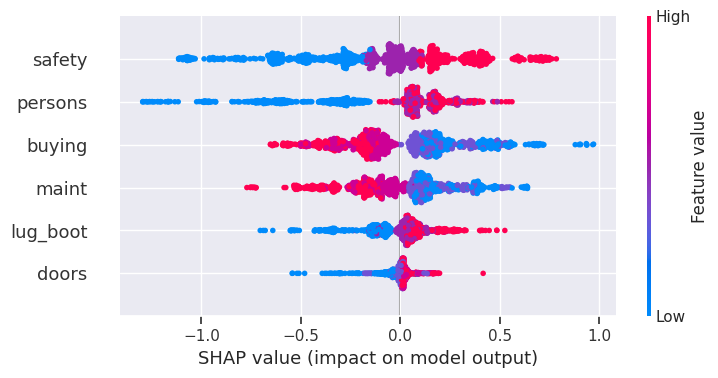

In [27]:
shap.plots.beeswarm(shap_values, max_display=20)

We can further evaluate the feature importance using the SHAP library. From the graph above, we can see that `persons` and `safety` are the most influential features on average.

It's noticeable that higher values of `persons` capacity and `safety` corresponds to increased market acceptability of the vehicle. Conversely, lower values of `buying`and `maintenance` prices are associates with higher positive vehicle evaluation.

These observations corroborate the analysis and insights derived from the Cross Category comparisons we made in the previous notebook.

## 5. Decision Tree Analysis
___

In this section, we'll plot a visualization of a Decision Tree Classifier, with Gini impurity as the splitting criterion.

For analysis purposes, we'll set a max_depth of 5.

The model was trained with the preprocessed UCI car evaluation dataset.

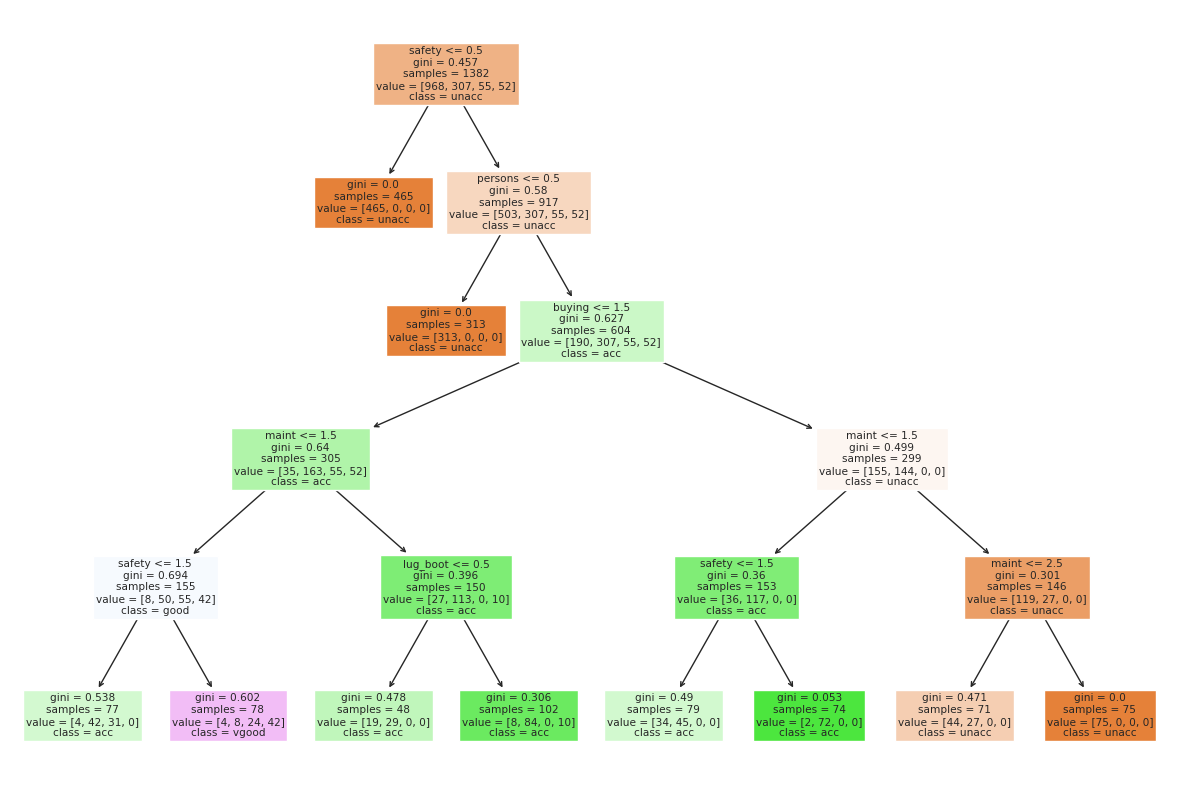

In [28]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5)
dtc.fit(X_train, y_train)

plt.figure(figsize=(15, 10))
plot_tree(dtc, filled=True, feature_names=list(X_train.columns), class_names=["unacc", "acc", "good", "vgood"])
plt.show()

As seen in the feature importance analysis, we observe in the first nodes of the decision tree that the `safety` and `persons` features are the ones that best help to separate the classes, according to the Gini impurity.

From the initial split criterion (safety <= 0.5), we can observe that the algorithm correctly classifies 33% (465 out of 1382) of the data as `unacc`. By incorporating the second split criterion (persons <= 0.5), it correctly classifies 56% of that data as `unacc`, which accounts for 80% of the entire `unacc` class from the training set.

Simply put, with only the information that a car has low safety (safety = 0) and low passenger capacity (persons = 2), we can correctly identify the vast majority of cases where cars will have a low rating (unacceptable class).

Subsequently, for the classification of the `acc`/`good`/`vgood` classes, the algorithm requires further information, considering additional features such as `buying` and `maintenance` prices, as evidenced by the subsequent split criteria.

For analytical purposes, a max_depth of 5 was set, limiting the tree depth to 5 split levels. This constraint may explain the presence of leaf nodes with non-zero Gini impurity, indicating that the splits made up to that point were insufficient for the model to fully separate the data into the presented classes.